In [9]:
from glob import glob 
import os
import cv2
import numpy as np
from scipy import io as sio
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
data_dir = None
output_dir = None
model_path = None
img_ext = None
ambi_path = None
if(not data_dir):
    print('Using Config file path for data_dir.')
    data_dir = '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images'
if(not output_dir):
    print('Using Config file path for output_dir.')
    output_dir = '/home/dm1/shikhar/check_sandbox/testing_code/testing_the_output'
if(not model_path):
    print('Using placeholder path for model_dir.')
    model_path = '/home/dm1/shikhar/check_sandbox/testing_code/model_saved/model-33198.index'
if(not img_ext):
    print('Using Config img ext value img_ext.')
    img_ext='.tif'
if(not ambi_path):
    # Hard coding path here for single test run. 
    ambi_path = '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/MoNuSAC_testing_ambiguous_regions'

#file_list = glob.glob('%s/*%s' % (data_dir, img_ext))
#file_list.sort() # ensure same order
#if(not file_list):
# print('No Images found in data_dir! Check script arg-paths') 
# Create Output Directory
#rm_n_mkdir(output_dir)       
# Expecting MoNuSAC's input data directory tree (Patient Name -> Image Name -> )

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
os.chdir(output_dir)
patients = [x[0] for x in os.walk(data_dir)]#Total patients in the data_path

print(len(patients))
print(patients)
sys.exit()
for patient_loc in patients:
    patient_name = patient_loc[len(data_dir)+1:]#Patient name
    #print(patient_name, flush=True)
    
    ## To make patient's name directory in the destination folder
    try:
        os.mkdir(patient_name)
    except OSError:
        print ("\n Creation of the patient's directory %s failed" % patient_name,  flush=True)

    sub_images = glob(str(patient_loc) + '/*' + str(img_ext))
    for sub_image_loc in sub_images:
        sub_image_name = sub_image_loc[len(data_dir)+len(patient_name)+1:-4]        
        #print(sub_image_name)
        
        ## To make sub_image directory under the patient's folder
        sub_image = './'+patient_name + sub_image_name #Destination path
        '''try:
            os.mkdir(sub_image)
        except OSError:
            print ("\n Creation of the patient's directory %s failed" % sub_image)
        
        image_name = sub_image_loc
        if(img_ext == '.svs'):
            img = openslide.OpenSlide(image_name)
            cv2.imwrite(sub_image_loc[:-4]+'.png', np.array(img.read_region((0,0),0,img.level_dimensions[0])))      
            img = cv2.imread(sub_image_loc[:-4]+'.png')
        else:
            img = cv2.imread(image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ## Generate Prediction Map
        pred_map = self.__gen_prediction(img, predictor)
        pred = pred_map
        # Process Prediction Map
        pred_inst = pred[...,self.nr_types:]
        pred_type = pred[...,:self.nr_types]
        pred_inst = np.squeeze(pred_inst)
        pred_type = np.argmax(pred_type, axis=-1)
        pred_inst = postproc.hover.proc_np_hv(pred_inst, 
                    marker_mode=marker_mode,
                    energy_mode=energy_mode, rgb=img)
        pred_inst = remap_label(pred_inst, by_size=True)
        
        # Map Instances to Labels for creating submission format
        pred_id_list = list(np.unique(pred_inst))[1:] # exclude background ID
        pred_inst_type = np.full(len(pred_id_list), 0, dtype=np.int32)
        for idx, inst_id in enumerate(pred_id_list):
            inst_type = pred_type[pred_inst == inst_id]
            type_list, type_pixels = np.unique(inst_type, return_counts=True)
            type_list = list(zip(type_list, type_pixels))
            type_list = sorted(type_list, key=lambda x: x[1], reverse=True)
            inst_type = type_list[0][0]
            if inst_type == 0: # ! pick the 2nd most dominant if exist
                if len(type_list) > 1:
                    inst_type = type_list[1][0]
                else:
                    print('[Warn] Instance has `background` type' )
            pred_inst_type[idx] = inst_type
        '''

        # Adding this part only for testing
        # '/home/dm1/shikhar/check_sandbox/testing_code/test_staging/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_1'
        # '/prediction.mat'
        pred_path = '/home/dm1/shikhar/check_sandbox/testing_code/test_staging'
        pred_inst = sio.loadmat(pred_path + '/' + patient_name + '/' + sub_image_name + '/prediction.mat')['n_ary_mask']
        #  ====== 
        # Read Ambiguous Region mask if any
        ambi_mask_final = None
        full_ambi_path = ambi_path + '/' + patient_name + '/' + sub_image_name + '/Ambiguous' 
        #print('\tAmbi Path: ',full_ambi_path)
        ambi_masks = glob(full_ambi_path+'/*')
        if(ambi_masks):
            try:
                ambi_mask_final = cv2.imread(ambi_masks[0])
                #print('Ambiguous Mask Found: ',ambi_mask_final.shape)
            
                # START CHANGES 
                gray = cv2.cvtColor(ambi_mask_final, cv2.COLOR_BGR2GRAY)
                count, ambi = cv2.connectedComponents(gray)
                #print('Ambiguous Regions (with Background): ',count)
                
                #print('Prediction: \n\tShape: %s\n\tUnique: %s' % (pred_inst.shape, np.unique(pred_inst)))
                #print('Ambiguous: \n\tShape: %s\n\tUnique: %s' % (ambi.shape, np.unique(ambi)))
                
                # Remove Ambiguous Regions from prediction
                # Format -> def get_fast_pq(true, pred, match_iou=0.5):
                match_iou = 0.01 # Modify parameter experimentally
                pairwise_iou = get_fast_pq(true = ambi, pred = pred_inst)
                matched_regions = np.array(pairwise_iou >= match_iou, np.uint8)
                matched_region_list = np.nonzero(matched_regions)[1]
                prediction_cleaned = pred_inst.copy()
                for id in matched_region_list:
                    region_id = id + 1
                    prediction_cleaned[prediction_cleaned == region_id] = 0
                
                
                # Show Overlay of Prediction & Ambi
                plt.imshow(pred_inst, 'gray', interpolation='none')
                plt.imshow(ambi, 'Paired', interpolation='none', alpha=0.7)
                plt.show()
                # Show Overlay of Prediction_cleaned & Ambi
                plt.imshow(prediction_cleaned, 'gray', interpolation='none')
                plt.imshow(ambi, 'Paired', interpolation='none', alpha=0.7)
                plt.show()
                '''#print('Prediction: ',np.unique(pred_inst))
                plt.imshow(pred_inst)
                plt.show()
                #print('Prediction Cleaned: ',np.unique(prediction_cleaned))
                plt.imshow(prediction_cleaned)
                plt.show()
                #print('Ambiguous: ',np.unique(ambi))
                plt.imshow(ambi)
                plt.show()'''
                print('Removed are: ', set(list(np.unique(pred_inst))) - set(list(np.unique(prediction_cleaned))) )
                say = input('Continue?')
                if((say=='y')| (say == 'Y')):
                    continue
                else:
                    sys.exit()
                # ========
            except Exception as e:
                print(e)
        else:
            print('\n\t # No Ambiguous Masks for this image: ', full_ambi_path)

'''        # Write Instance Maps based on their Classes/Labels to the folders
        for class_id in range(1,self.nr_types):
            separated_inst = pred_inst.copy()
            separated_inst[pred_inst_type[separated_inst-1]!=[class_id]] = 0
            # Create directory for each label
            label = class_id_mapping[class_id]
            sub_path = sub_image+'/'+label
            try:
                os.mkdir(sub_path)
            except OSError:
                print ("Creation of the directory %s failed" % label)
            else:
                print ("Successfully created the directory %s " % label)

            sio.savemat(sub_path +'/maskorempty.mat', 
                {'n_ary_mask'  :  separated_inst})'''

Using Config file path for data_dir.
Using Config file path for output_dir.
Using placeholder path for model_dir.
Using Config img ext value img_ext.
26
['/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-EW-A6SB-01Z-00-DX1', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-IZ-A6M9-01Z-00-DX1', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-55-7573-01Z-00-DX1', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-A2-A04X-01Z-00-DX1', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-73-4662-01Z-00-DX1', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-A2-A0ES-01Z-00-DX1', '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-DW-7963-01Z-00-DX1', '/hom

SystemExit: 

### Testing Ambiguous Region Removal Algorithm

In [1]:
from scipy.optimize import linear_sum_assignment

def get_fast_pq(true, pred, match_iou=0.5):
    """
    From Hover-Net: Simon Graham .et.al. 
    `match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
    (1 prediction instance to 1 GT instance mapping).

    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing. 

    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.    
    
    Fast computation requires instance IDs are in contiguous orderding 
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand 
    and `by_size` flag has no effect on the result.

    Returns:
        [dq, sq, pq]: measurement statistic

        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"
    
    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)
    
    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros([len(true_id_list) -1, 
                             len(pred_id_list) -1], dtype=np.float64)

    # caching pairwise iou
    for true_id in true_id_list[1:]: # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0: # ignore
                continue # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id-1, pred_id-1] = iou

    return pairwise_iou

In [1]:
# Sample Ambiguous Region
from glob import glob 
import os
import cv2
import numpy as np
from scipy import io as sio
import matplotlib.pyplot as plt
from IPython.display import clear_output
_ambiguous = cv2.imread('/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/MoNuSAC_testing_ambiguous_regions/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_1/Ambiguous/5_mask.tif')
gray = cv2.cvtColor(_ambiguous, cv2.COLOR_BGR2GRAY)
count, ambi = cv2.connectedComponents(gray)

In [2]:
path = '/home/dm1/shikhar/check_sandbox/testing_code/test_output_1/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_1'
try:
    e_image = sio.loadmat(path + '/Epithelial/maskorempty.mat')['n_ary_mask']
    l = sio.loadmat(path + '/Lymphocyte/maskorempty.mat')['n_ary_mask']
    m = sio.loadmat(path + '/Macrophage/maskorempty.mat')['n_ary_mask']
    n = sio.loadmat(path + '/Neutrophil/maskorempty.mat')['n_ary_mask']
except Exception as e:
    print('Exception: ',e)

In [3]:
path = '/home/dm1/shikhar/check_sandbox/testing_code/test_staging/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_1'
try:
    prediction = sio.loadmat(path + '/prediction.mat')['n_ary_mask']
except Exception as e:
    print('Exception: ',e)

In [4]:
img_path = '/home/dm1/shikhar/check_sandbox/testing_code/MoNuSAC_testing_data/Testing_images/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_1.tif'
img = cv2.imread(img_path)

In [5]:
# Format -> def get_fast_pq(true, pred, match_iou=0.5):
match_iou = 0.4 # Modify parameter experimentally
pairwise_iou = get_fast_pq(true = ambi, pred = prediction)
matched_regions = np.array(pairwise_iou >= match_iou, np.uint8)
matched_region_list = np.nonzero(matched_regions)[1]
prediction_cleaned = prediction.copy()
for id in matched_region_list:
    region_id = id + 1
    prediction_cleaned[prediction_cleaned == region_id] = 0


NameError: name 'get_fast_pq' is not defined

In [ ]:
    plt.imshow(img)
    plt.show()
    print('Prediction: ',np.unique(prediction))
    plt.imshow(prediction)
    plt.show()
    print('Prediction Cleaned: ',np.unique(prediction_cleaned))
    plt.imshow(prediction_cleaned)
    plt.show()
    print('Ambiguous')
    plt.imshow(ambi)
    plt.show()
    print('Old: ')
    plt.imshow(e_image)
    plt.show()
    print(np.unique(e_image,return_counts = True))
    plt.imshow(l)
    plt.show()
    print(np.unique(l,return_counts = True))
    plt.imshow(m)
    plt.show()
    print(np.unique(m,return_counts = True))
    plt.imshow(n)
    plt.show()
    print(np.unique(n,return_counts = True))

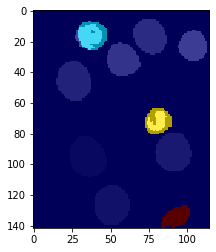

In [7]:
plt.imshow(prediction, 'gray', interpolation='none')
plt.imshow(ambi, 'jet', interpolation='none', alpha=0.7)
plt.savefig('/home/dm1/shikhar/check_sandbox/testing_code/metrics/test.png')

In [54]:
output = get_fast_pq(ambi, prediction)
#def get_fast_pq(true, pred, match_iou=0.5):

In [55]:
output

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.61513158, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.43776824],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [9]:
pred = prediction
true = ambi

In [10]:
true = np.copy(true)
pred = np.copy(pred)
true_id_list = list(np.unique(true))
pred_id_list = list(np.unique(pred))

In [11]:
true_id_list

[0, 1, 2, 3]

In [12]:
pred_id_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
list(set(pred_id_list - true_id_list

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [60]:
true_masks = [None,]
# Creating binary masks for connected components
for t in true_id_list[1:]:
    t_mask = np.array(true == t, np.uint8)
    true_masks.append(t_mask) 

pred_masks = [None,]
for p in pred_id_list[1:]:
    p_mask = np.array(pred == p, np.uint8)
    pred_masks.append(p_mask)

In [61]:
true_masks

[None,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

Testing

a = true_masks[1]

a.shape

np.unique(a, return_counts= True)

 b = pred_masks[8]

In [91]:
b.shape

(142, 115)

In [92]:
np.unique(b, return_counts= True)

(array([0, 1], dtype=uint8), array([16121,   209]))

In [93]:
(a+b).shape

(142, 115)

In [94]:
np.unique(a + b, return_counts = True)

(array([0, 1, 2], dtype=uint8), array([16026,   117,   187]))

In [95]:
np.unique(a * b, return_counts = True)

(array([0, 1], dtype=uint8), array([16143,   187]))

In [96]:
(a * b).shape

(142, 115)

Testing end

In [63]:
# prefill with value
# pairwise_iou: [true_id_list] * [pred_id_list]
pairwise_iou = np.zeros([len(true_id_list) -1, 
                            len(pred_id_list) -1], dtype=np.float64)


In [64]:
pairwise_iou

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [70]:
# caching pairwise iou
for true_id in true_id_list[1:]: # 0-th is background
    t_mask = true_masks[true_id]
    pred_true_overlap = pred[t_mask > 0]
    print(pred_true_overlap)
    pred_true_overlap_id = np.unique(pred_true_overlap)
    print(pred_true_overlap_id)
    pred_true_overlap_id = list(pred_true_overlap_id)
    for pred_id in pred_true_overlap_id:
        if pred_id == 0: # ignore
            continue # overlaping background
        p_mask = pred_masks[pred_id]
        total = (t_mask + p_mask).sum()
        inter = (t_mask * p_mask).sum()
        iou = inter / (total - inter)
        pairwise_iou[true_id-1, pred_id-1] = iou

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 0 0 0 0 0 0 0 8 8 8 8 8 8 8
 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0
 0 0 0 8 8 8 8 8 8 8 8 8 0 8 8 8 8 8 0 0 0 0 8 8 8 8 8 8 8 8 8 0 0 8 8 8 8
 8 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 0
 0 0 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 8 8 8 8 8
 8 8 0 0 0 0 0 0 8 8 8 8 8 8 0 0 0 8 8 0 0 0 0]
[0 8]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 9 9 9 9 0 0 0 0 0 0 0 9 9 9
 9 9 9 9 0 0 0 0 0 0 0 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 0 0 0
 0 0 9 0 0 0 0 9 9 9 9 9 9 0 0 0 0 0 0 9 0 0 0 0 9 9 9 9 9 9 0 0 0 0 0 9 9
 0 9 0 0 9 9 9 9 9 9 0 0 0 0 0 9 9 9 9 0 0 9 9 9 9 9 9 0 0 0 0 0 9 9 9 9 0
 0 9 9 9 9 9 9 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 9 9 9 9 9 9 9
 9 9 9 0 0 0 0 0 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0

In [72]:
pairwise_iou[true_id_list][pred_id_list]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.61513158, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.43776824],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [103]:
matched_regions = np.array(pairwise_iou >= match_iou, np.uint8)

In [105]:
matched_regions

array([[0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [107]:
matched_region_list = np.nonzero(matched_regions)[1]

In [108]:
prediction_cleaned = prediction.copy()
for id in matched_region_list:
    region_id = id + 1
    prediction_cleaned[prediction_cleaned == region_id] = 0

In [109]:
np.unique(prediction_cleaned)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [110]:
print(matched_region_list)

[7 8]


#### Collected script

In [ ]:
# Format -> def get_fast_pq(true, pred, match_iou=0.5):
match_iou = 0.4 # Modify parameter experimentally
pairwise_iou = get_fast_pq(true = ambi, pred = prediction)
matched_regions = np.array(pairwise_iou >= match_iou, np.uint8)
matched_region_list = np.nonzero(matched_regions)[1]
prediction_cleaned = prediction.copy()
for id in matched_region_list:
    region_id = id + 1
    prediction_cleaned[prediction_cleaned == region_id] = 0


[0 1 2 3 4 5 6 7 8 9]


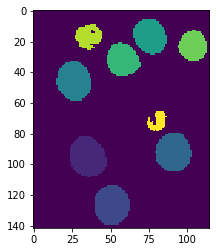

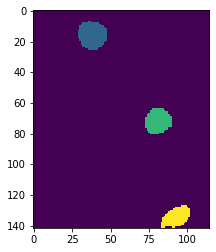

[0 1 2 3 4 5 6 7]


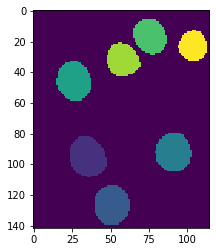

In [114]:
plt.imshow(prediction)
print(np.unique(prediction))
plt.show()
plt.imshow(ambi)
plt.show()
plt.imshow(prediction_cleaned)
print(np.unique(prediction_cleaned))
plt.show()